### Data Preprocessing for Model Training

In [1]:
import os 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

SEED = 42

IMAGE_DIR = "data/Images/"

existing_image_files = os.listdir(IMAGE_DIR)

df = pd.read_csv('data/data.csv').drop(columns=['Unnamed: 0'])
df.head()

,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
4,37.758789,Female,1,img_4.bmp


In [4]:
print(df['bmi'].min())
print(df['bmi'].max())

17.7162162162
85.9870605469


<Axes: >

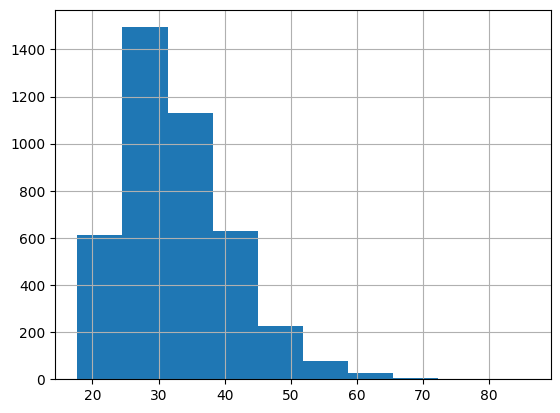

In [2]:
df['bmi'].hist()

In [2]:
labeled_data = df[df["name"].isin(existing_image_files)]
unlabeled_data = df[~df["name"].isin(existing_image_files)]
print(f"Size of the labeled_data: {labeled_data.shape[0]}, {((labeled_data.shape[0]/df.shape[0]) * 100):.2f}%")
print(f"Size of the unlabeled_data: {unlabeled_data.shape[0]}, {((unlabeled_data.shape[0]/df.shape[0]) * 100):.2f}%")

Size of the labeled_data: 3962, 94.20%
Size of the unlabeled_data: 244, 5.80%


Use labeled data for training. Can consider using unlabeled data for visual validation and possibly add high confidence images to dataset for training. 

In [3]:
# Split dataset used for training dataset
training_data = labeled_data[labeled_data['is_training'] == 1].reset_index(drop=True)
testing_data = labeled_data[labeled_data['is_training'] == 0].reset_index(drop=True)
print(f"Size of the training_data: {training_data.shape[0]}, {((training_data.shape[0]/labeled_data.shape[0]) * 100):.2f}%")
print(f"Size of the testing_data: {testing_data.shape[0]}, {((testing_data.shape[0]/labeled_data.shape[0]) * 100):.2f}%")

Size of the training_data: 3210, 81.02%
Size of the testing_data: 752, 18.98%


In [4]:
# Split training data into training and validation sets and save into data/train/ and data/validation/
VALIDATION_SIZE = 0.1
training_data_post_split, validation_data_post_split = train_test_split(training_data, test_size=VALIDATION_SIZE, random_state=SEED)
print(f"Size of the training_data: {training_data_post_split.shape[0]}, {((training_data_post_split.shape[0]/labeled_data.shape[0]) * 100):.2f}%")
print(f"Size of the validation_data: {validation_data_post_split.shape[0]}, {((validation_data_post_split.shape[0]/labeled_data.shape[0]) * 100):.2f}%")
print(f"Size of the testing_data: {testing_data.shape[0]}, {((testing_data.shape[0]/labeled_data.shape[0]) * 100):.2f}%")

Size of the training_data: 2889, 72.92%
Size of the validation_data: 321, 8.10%
Size of the testing_data: 752, 18.98%


In [5]:
# Save training and testing data
data_dir = "data/"
train_dir = os.path.join(data_dir, "train")
validation_dir = os.path.join(data_dir, "validation")
test_dir = os.path.join(data_dir, "test")

train_annotation_file_path =os.path.join(train_dir, "train_data.csv")
validation_annotation_file_path = os.path.join(validation_dir, "validation_data.csv")
test_annotation_file_path = os.path.join(test_dir, "test_data.csv")

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

training_data_post_split.to_csv(train_annotation_file_path)
validation_data_post_split.to_csv(validation_annotation_file_path)
testing_data.to_csv(test_annotation_file_path)

### Prepare Dataset For PyTorch

In [6]:
import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import numpy as np

import cv2
import numpy as np
import mediapipe as mp
from PIL import Image
import torch
from torchvision.transforms import v2
    
class BMIImageDataset(Dataset):
    """
    Custom PyTorch Dataset for BMI Images

    Inherits from torch.utils.data.Dataset to create a an iterable dataset
    """
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """
        Initialize the dataset
        Args:
            annotations_file (str): file path to the csv file containing the image names and labels
            img_dir (str): directory containing the images
            transform (_type_, optional): _description_. Defaults to None.
            target_transform (_type_, optional): _description_. Defaults to None.
        """
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        # Ensure to transform image to tensor
        if self.transform is None:
            self.transform = v2.ToTensor()

    def __len__(self):
        """
        Returns the number of images in the dataset
        """
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Get an image and label at a given index
        """
        row = self.img_labels.iloc[idx]
        img_path = os.path.join(self.img_dir, row['name'])
        image = Image.open(img_path).convert('RGB')
        label = row['bmi']
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, torch.tensor(label, dtype=torch.float32)


In [7]:
import torch
import numpy as np
import cv2
from PIL import Image
import mediapipe as mp
from torchvision import transforms

class MediaPipeFaceAlignTransform:
    """
    Detects a single face via MediaPipe FaceMesh, aligns it so the eyes are horizontal,
    crops to the face region plus a margin, and resizes to `output_size`.
    """

    def __init__(self, output_size=(224, 224), margin=0.2, 
                 min_detection_confidence=0.5, max_num_faces=1):
        self.output_size = output_size
        self.margin = margin
        # MediaPipe FaceMesh
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=max_num_faces,
            refine_landmarks=True,
            min_detection_confidence=min_detection_confidence
        )

    def __call__(self, img):
        """
        img: PIL Image or torch.Tensor
        returns: aligned, cropped, resized PIL Image
        """
        # 1. Convert to RGB numpy array
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)
        img = img.convert("RGB")
        img_np = np.array(img)
        h, w, _ = img_np.shape

        # 2. Run MediaPipe FaceMesh
        results = self.face_mesh.process(img_np)
        # if no face is detected, center‐crop & resize
        if not results.multi_face_landmarks:
            pil = Image.fromarray(img_np)
            return pil.crop(self._center_box(pil)).resize(self.output_size)
        
        # take the first face
        lm = results.multi_face_landmarks[0].landmark

        # 3. Compute eye centers (using outer/inner corners)
        left_idxs  = [33, 133]   # eye outer/inner
        right_idxs = [362, 263]
        left_eye  = np.mean([(lm[i].x * w, lm[i].y * h) for i in left_idxs],  axis=0)
        right_eye = np.mean([(lm[i].x * w, lm[i].y * h) for i in right_idxs], axis=0)

        # 4. Compute rotation angle
        dx, dy = right_eye - left_eye
        angle = np.degrees(np.arctan2(dy, dx))

        # 5. Rotate image around its center
        center = (w / 2, h / 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img_np, M, (w, h), flags=cv2.INTER_LINEAR)

        # 6. Rotate all landmarks
        pts = np.array([[p.x * w, p.y * h] for p in lm])
        pts_hom = np.concatenate([pts, np.ones((pts.shape[0],1))], axis=1)  # Nx3
        pts_rot = pts_hom @ M.T  # Nx2

        # 7. Build bounding box around rotated landmarks + margin
        xs, ys = pts_rot[:,0], pts_rot[:,1]
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        pad_x = (x_max - x_min) * self.margin
        pad_y = (y_max - y_min) * self.margin
        x1 = int(max(0, x_min - pad_x))
        y1 = int(max(0, y_min - pad_y))
        x2 = int(min(w, x_max + pad_x))
        y2 = int(min(h, y_max + pad_y))

        # 8. Crop and resize
        face_crop = rotated[y1:y2, x1:x2]
        face_pil = Image.fromarray(face_crop).resize(self.output_size, Image.BILINEAR)
        return face_pil

    def _center_box(self, pil_img):
        w, h = pil_img.size
        # square center box (min dimension)
        side = min(w, h)
        left = (w - side) // 2
        top  = (h - side) // 2
        return (left, top, left+side, top+side)

Below contains the image transformations for the dataset. These are needed to add diversity and to preprocess the dataset for the pre-trained models being used for the face detection. Here are some notes taken for why each data transformation occurs.

- `v2.Resize((224, 224))`: Resize all images to 224x224 to match dimension defined in pre-trained model
- `v2.RandomHorizontalFlip()`: 
- `v2.ColorJitter(brightness=0.2, contrast=0.2)`,
- `v2.ToTensor()`, # Convert PIL image to tensor
- `v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` # Follow ImageNet normalization standard

Updated to use MediaPipeFaceAlignTransform for face alignment. This model is used to align the face based off identifying landmarks (eyes, and mouth) and then rotating the image to align the eyes and center the face for smoother results after training the model for BMI prediction.

In [8]:
from torchvision import transforms as v2

train_transforms = v2.Compose([
    MediaPipeFaceAlignTransform(output_size=(224,224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(0.2,0.2,0.2),
    v2.RandomAffine(degrees=5, translate=(0.02,0.02),
                    scale=(0.95,1.05), shear=2),
    v2.RandomApply([v2.GaussianBlur(3)], p=0.1),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485,0.456,0.406],
                 std=[0.229,0.224,0.225]),
])

val_test_transforms = v2.Compose([
    MediaPipeFaceAlignTransform(output_size=(224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485,0.456,0.406],
                 std=[0.229,0.224,0.225]),
])

I0000 00:00:1747108317.894081       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1747108317.908822       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Pro


In [9]:
# Normalize BMI labels for training dataset
bmis = np.array([row['bmi'] for _, row in training_data_post_split.iterrows()])
bmi_mean, bmi_std = bmis.mean(), bmis.std()

# 2) Define your target_transform
def standardize_bmi(x):
    return (x - bmi_mean) / bmi_std

def unstandardize_bmi(x):
    return x * bmi_std + bmi_mean

In [10]:
train_dataset = BMIImageDataset(train_annotation_file_path, IMAGE_DIR, train_transforms, standardize_bmi)
val_dataset = BMIImageDataset(validation_annotation_file_path, IMAGE_DIR, val_test_transforms)
test_dataset = BMIImageDataset(test_annotation_file_path, IMAGE_DIR, val_test_transforms)

In [11]:
# Use dataloader to load data
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
def view_image(data_loader, show_normalized=False):
    # Get a batch of data from the dataloader
    data_iter = iter(data_loader)
    
    # Extract images and labels from batch
    images, labels = next(data_iter)
    
    # Display the first image in the batch
    image = images[0]
    label = labels[0]
    
    # Check if the image is on the GPU, move to CPU if necessary
    if image.is_cuda:
        image = image.cpu()

    # Remove batch dimension and change channel-first to channel-last if needed
    # Transpose image to match dimension from RGB to HWC
    image = image.squeeze(0).permute(1, 2, 0)

    # Convert to NumPy array
    image_np = image.numpy()

    if not show_normalized:
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    # Display the image
    plt.title(f'BMI: {label:.1f}')
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image_np)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9951199].


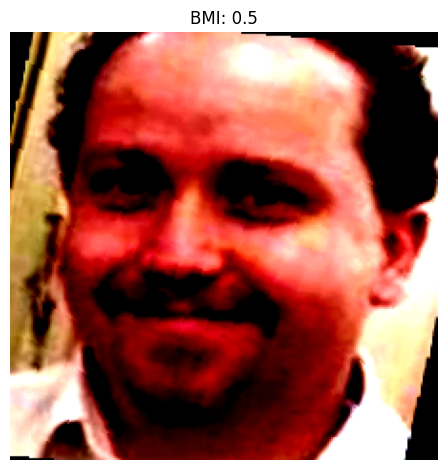

In [13]:
view_image(train_dataloader, show_normalized=True)

### Model Training

In [14]:
import os
from pathlib import Path

# Create model directory
model_dir = Path('saved_models')
model_dir.mkdir(exist_ok=True)

# Print the absolute path
print(f"Model directory: {model_dir.absolute()}")

# List any existing files
print("\nFiles in model directory:")
for file in model_dir.glob('*'):
    print(f"- {file.name}")

Model directory: /Users/sagana/Documents/UChicago/Spring 2025/Machine Learning II/Assignments/ML_II_Final_Project/saved_models

Files in model directory:
- best_bmi_model_xgboost.joblib
- best_bmi_multimodal_model.pth
- best_bmi_model_xgboost.pkl
- arcface_bmi_embedder.pth


In [15]:
import torch
import torch.nn as nn
from torch import optim
import insightface
from insightface.model_zoo import get_model
import os
from pathlib import Path

# Create a directory for model weights if it doesn't exist
model_dir = Path('saved_models')
model_dir.mkdir(exist_ok=True)

# Define the model architecture
class BMIRegressor(nn.Module):
    def __init__(self, backbone):
        super(BMIRegressor, self).__init__()
        self.backbone = backbone
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        # The backbone expects a specific input format
        features = self.backbone.get_feat(x)
        bmi = self.fc(features)
        return bmi

# Initialize model
try:
    # Set the model download directory
    insightface.model_zoo.get_model_dir = lambda: str(model_dir)
    
    # Load the backbone model using the correct function
    print("Attempting to load model...")
    print(f"Model directory: {model_dir.absolute()}")
    
    # Try loading the buffalo_l model
    backbone = get_model('buffalo_l', pretrained=True)
    
    if backbone is None:
        raise ValueError("Model loading failed - backbone is None")
        
    print("Model loaded successfully")
    print("Model type:", type(backbone))
except Exception as e:
    print(f"Error loading pre-trained model: {str(e)}")
    print("Please ensure you have a stable internet connection and sufficient disk space.")
    print(f"Model directory: {model_dir.absolute()}")
    # List any files in the model directory
    print("\nFiles in model directory:")
    for file in model_dir.glob('*'):
        print(f"- {file.name}")
    raise

model = BMIRegressor(backbone)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-4}  # Only optimize the fully connected layers
])

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

Attempting to load model...
Model directory: /Users/sagana/Documents/UChicago/Spring 2025/Machine Learning II/Assignments/ML_II_Final_Project/saved_models
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
Model loaded successfully
Model type: <class 'insightface.model_zoo.arcface_onnx.ArcFaceONNX'>


/Users/sagana/Documents/UChicago/Spring 2025/Machine Learning II/Assignments/ML_II_Final_Project/ml_env/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [16]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [17]:
# Training parameters
num_epochs = 50
best_val_loss = float('inf')

# Create directory for saving models
os.makedirs('model_checkpoints', exist_ok=True)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_checkpoints/best_model.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Loss: {avg_val_loss:.4f}')
    print('-' * 50)


error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'blobFromImages'
> Overload resolution failed:
>  - Can't parse 'images'. Sequence item with index 0 has a wrong type
>  - Can't parse 'images'. Sequence item with index 0 has a wrong type


In [ ]:
# (Optional) Freeze all but the last block for the first few epochs
for name, param in backbone.named_parameters():
    if not name.startswith('res5'):   # only fine-tune layers in the last ResNet block
        param.requires_grad = False

In [17]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir logs